In [1]:
import os

import argparse
import numpy as np
import random
import sys
import time
import shutil
from importlib import import_module
from numbers import Number

import torch
from torch.utils.data import Sampler, DataLoader


from utils import Logger, load_pretrain

from lanegcn import get_model

In [2]:
config, Dataset, collate_fn, net, loss, post_process, opt = get_model()

In [3]:
def worker_init_fn(pid):
    np_seed = int(pid)
    np.random.seed(np_seed)
    random_seed = np.random.randint(2 ** 32 - 1)
    random.seed(random_seed)

dataset = Dataset('./dataset/train_mini/data', config, train=True)
train_loader = DataLoader(
        dataset,
        batch_size=config["batch_size"],
        num_workers=config["workers"],
        shuffle=False,   # True: At each epoch, reorder the data
        collate_fn=collate_fn,
        pin_memory=True,
        worker_init_fn=worker_init_fn,   # The next 36 were thrown away
        drop_last=True,
    )

In [11]:
data = {}
for i, data in enumerate(train_loader):
    data = dict(data)
    break

print(data.keys())

dict_keys(['city', 'trajs', 'steps', 'feats', 'traj1', 'ctrs', 'orig', 'theta', 'rot', 'gt_preds', 'has_preds', 'trajs2', 'idx', 'graph'])


In [12]:
from lanegcn import actor_gather, graph_gather, ActorNet, MapNet, A2M, A2A,M2A,M2M

In [13]:
a2m = A2M(config)
m2m = M2M(config)
m2a = M2A(config)
a2a = A2A(config)
actor_net = ActorNet(config)
map_net = MapNet(config)

In [15]:

# construct actor feature
actors, actor_idcs = actor_gather(data["feats"])
actor_ctrs = data["ctrs"]
actors = actor_net(actors)

In [16]:
actors.size()

torch.Size([528, 128])

In [17]:
from lanegcn import PredNet
pred_net = PredNet(config)
out = pred_net(actors, actor_idcs, actor_ctrs)

In [22]:
len(out['cls'])

32

In [25]:
out['cls'][2].size()

torch.Size([5, 6])

In [6]:
print(data['city'])
print(len(data['trajs']))
print(len(data['trajs'][0]))
# for i in range(32):
#     print(dataset[i]['city'])

print(data['trajs'])

['PIT', 'MIA', 'PIT', 'MIA', 'MIA', 'PIT', 'PIT', 'MIA', 'PIT', 'PIT', 'MIA', 'MIA', 'MIA', 'MIA', 'MIA', 'MIA', 'PIT', 'MIA', 'MIA', 'PIT', 'PIT', 'PIT', 'PIT', 'MIA', 'MIA', 'MIA', 'PIT', 'MIA', 'PIT', 'PIT', 'PIT', 'MIA']
32
12
[[tensor([[2687.0726, 1170.6773],
        [2688.3371, 1171.7875],
        [2689.5978, 1173.0056],
        [2690.7607, 1174.0459],
        [2691.8842, 1175.0875],
        [2692.7317, 1175.8268],
        [2693.9610, 1177.1004],
        [2695.0147, 1177.9411],
        [2696.1890, 1179.1000],
        [2697.2968, 1180.0365],
        [2698.4726, 1181.1631],
        [2699.5914, 1182.2609],
        [2700.8065, 1183.2653],
        [2701.7638, 1184.2327],
        [2702.9698, 1185.3120],
        [2704.1260, 1186.4402],
        [2705.2801, 1187.4014],
        [2706.6702, 1188.7234],
        [2707.5216, 1189.4619],
        [2708.6663, 1190.5678],
        [2709.8375, 1191.5655],
        [2710.8836, 1192.6608],
        [2712.2673, 1193.8563],
        [2713.1527, 1194.7028],

In [7]:
from argoverse.data_loading.argoverse_forecasting_loader import ArgoverseForecastingLoader
from argoverse.map_representation.map_api import ArgoverseMap

# avl = ArgoverseForecastingLoader('./dataset/train_mini/data')
# print(avl[0])

split = np.load('./dataset/preprocess/train_crs_dist6_angle90.p', allow_pickle=True)

print(len(split))
# print(split[1])
print(split[0].keys())
print(split[9]['feats'].size)



110
dict_keys(['idx', 'city', 'feats', 'ctrs', 'orig', 'theta', 'rot', 'gt_preds', 'has_preds', 'graph', 'trajs', 'traj1'])
420


In [8]:
print(len(dataset.split))

110


In [9]:
dataset = Dataset('./dataset/preprocess/train_crs_dist6_angle90.p', config, train=True)

In [10]:
for i, data in enumerate(train_loader):
    data =dict(data) 
    print('i =', i,'len = ', len(data['city']))

print(i)

i = 0 len =  32
i = 1 len =  32
i = 2 len =  32
2


In [11]:
print(data.keys(), len(data['city']))
# print(data['gt_preds'])
print(len(data['graph']), data['graph'][0].keys())
print(len(data['feats']), data['feats'][0].size())

dict_keys(['city', 'orig', 'gt_preds', 'has_preds', 'theta', 'rot', 'feats', 'ctrs', 'graph', 'trajs', 'traj1']) 32
32 dict_keys(['ctrs', 'num_nodes', 'feats', 'turn', 'control', 'intersect', 'pre', 'suc', 'lane_idcs', 'pre_pairs', 'suc_pairs', 'left_pairs', 'right_pairs', 'left', 'right'])
32 torch.Size([12, 20, 3])


In [12]:
print(data['city'][0:5])

['MIA', 'MIA', 'PIT', 'PIT', 'MIA']


In [13]:
print(len(data['gt_preds']), data['gt_preds'][0].size())

32 torch.Size([12, 30, 2])


32
dict_keys(['ctrs', 'num_nodes', 'feats', 'turn', 'control', 'intersect', 'pre', 'suc', 'lane_idcs', 'pre_pairs', 'suc_pairs', 'left_pairs', 'right_pairs', 'left', 'right'])
torch.Size([1431, 2]) tensor([[ 78.8280, -70.3307],
        [ 80.1185, -70.0442],
        [ 81.4089, -69.7577],
        ...,
        [ 95.3565,  71.6838],
        [ 95.1766,  72.4025],
        [ 94.9967,  73.1211]])
1431
torch.Size([12, 20, 3])
tensor([ 1.0263e+00, -6.4420e-07])
tensor([[ 0.0000e+00,  0.0000e+00],
        [-1.0247e-01,  5.9214e-01],
        [ 7.1112e-01, -4.0717e-01],
        [ 4.1534e-01,  4.0864e-02],
        [ 4.7127e-01, -2.9227e-01],
        [ 1.1025e+00, -3.0220e-01],
        [ 4.8492e-01, -1.5746e-01],
        [ 6.4992e-01, -1.3299e-01],
        [ 6.6781e-01, -1.6725e-01],
        [ 4.6423e-01, -8.7786e-02],
        [ 3.2890e-01, -8.8570e-02],
        [ 1.2687e+00, -1.3822e-01],
        [ 5.5424e-01, -5.0619e-02],
        [ 5.1367e-01, -5.6269e-02],
        [ 1.3857e+00,  1.7025e-02],
    

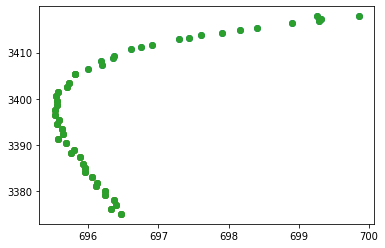

In [14]:
print(len(data['graph']))
print(data['graph'][0].keys())
print(data['graph'][0]['ctrs'].size(), data['graph'][0]['ctrs'])
ctrs0 = data['graph'][0]['ctrs']
ctrs1 = data['graph'][1]['ctrs']
x0 = ctrs0[:,0]
y0 = ctrs0[:,1]
x1 = ctrs1[:,0]
y1 = ctrs1[:,1]

import matplotlib.pyplot as plt
# plt.scatter(x0, y0)
# plt.scatter(x1, y1)

print(data['graph'][0]['num_nodes'])

# print(data['ctrs'][0].size())
# plt.scatter(data['ctrs'][0][:,0], data['ctrs'][0][:,1])

ctrs = data['ctrs'][0]
feat = data['feats'][0]
print(data['feats'][0].size())
# print(data['feats'][0][0], len(data['feats'][0][0]))

print(feat[0][-1, :2])   # ctrs is the last row of feat

# print(feat[0][:, :2])
# a = feat[0][:,:2].clone()
# a[19] = ctrs[0]

for j in range(len(ctrs)):
    a = feat[j][:,:2].clone()
    a[19] = ctrs[j]
    for i in range(18):
        a[18-i] = a[19-i] - feat[j][19-i,:2]
        # plt.scatter(a[:,0], a[:,1])
        print(a, a.size())
        break
    break
       
# print(a)


traj1 = data['traj1'][0]
x2 = traj1[0][:,0]
y2 = traj1[0][:,1]
print(traj1[0], traj1[0].size())
# plt.scatter(x2,y2)
print(data['trajs'][0][0])
print(data['gt_preds'][0][0])
plt.scatter(data['trajs'][0][0][:,0],data['trajs'][0][0][:,1])
plt.scatter(data['gt_preds'][0][0][:,0],data['gt_preds'][0][0][:,1])
print(a - traj1[0][:,:2])
print(traj1[1,:,:2])
print(type(data['trajs'][0][0]))
traj = torch.cat((data['trajs'][0][0][:,:2].float(),data['gt_preds'][0][0]), dim=0)
print(traj)
plt.scatter(traj[:,0], traj[:,1])

actor_0

tensor(0.) tensor(0.)


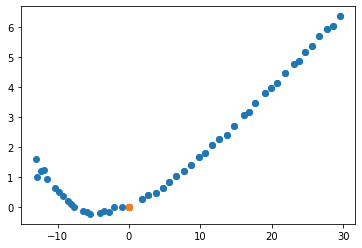

In [15]:
orig = data['orig'][0]
trajs = data['trajs'][0][0]
pre = trajs[18] - orig
theta = np.pi - np.arctan2(pre[1], pre[0])

rot = np.asarray([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]], np.float32)

trajs = np.matmul(rot, (traj - orig.reshape(-1, 2)).T).T
plt.scatter(trajs[:,0], trajs[:,1])
plt.scatter(trajs[19,0], trajs[19,1])
print(trajs[19,0], trajs[19,1])

all actoar trajs

In [16]:
print(len(data['trajs'][0]))
print(len(data['gt_preds'][0]))

46
12


tensor(0.) tensor(0.)


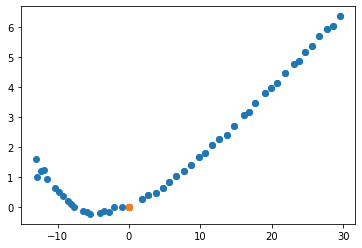

In [17]:
orig = data['orig'][0]
trajs = data['trajs'][0]
pre = trajs[0][18] - orig
theta = np.pi - np.arctan2(pre[1], pre[0])

rot = np.asarray([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]], np.float32)

trajs = np.matmul(rot, (traj - orig.reshape(-1, 2)).T).T
plt.scatter(trajs[:,0], trajs[:,1])
plt.scatter(trajs[19,0], trajs[19,1])
print(trajs[19,0], trajs[19,1])

dict_keys(['ctrs', 'num_nodes', 'feats', 'turn', 'control', 'intersect', 'pre', 'suc', 'lane_idcs', 'pre_pairs', 'suc_pairs', 'left_pairs', 'right_pairs', 'left', 'right'])
torch.Size([1431, 2])


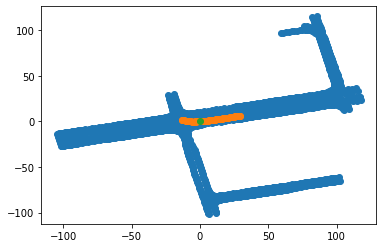

In [18]:
graph = data['graph'][0]
print(graph.keys())
g_ctrs = graph['ctrs']
print(g_ctrs.size())

plt.scatter(g_ctrs[:,0], g_ctrs[:,1])
plt.scatter(trajs[:,0], trajs[:,1])
plt.scatter(trajs[19,0], trajs[19,1])

In [19]:
print(orig)
print(trajs)

tensor([ 695.8059, 3405.3269])
tensor([[-1.2956e+01,  1.0185e+00],
        [-1.3058e+01,  1.6106e+00],
        [-1.2347e+01,  1.2035e+00],
        [-1.1932e+01,  1.2443e+00],
        [-1.1460e+01,  9.5204e-01],
        [-1.0358e+01,  6.4983e-01],
        [-9.8731e+00,  4.9239e-01],
        [-9.2232e+00,  3.5938e-01],
        [-8.5552e+00,  1.9216e-01],
        [-8.0910e+00,  1.0441e-01],
        [-7.7621e+00,  1.5804e-02],
        [-6.4936e+00, -1.2244e-01],
        [-5.9393e+00, -1.7308e-01],
        [-5.4255e+00, -2.2927e-01],
        [-4.0399e+00, -2.1232e-01],
        [-3.5682e+00, -1.3231e-01],
        [-2.8367e+00, -1.6980e-01],
        [-2.0932e+00, -1.0415e-02],
        [-1.0261e+00, -1.2989e-05],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 1.8087e+00,  2.7296e-01],
        [ 2.6776e+00,  4.0361e-01],
        [ 3.7478e+00,  4.7925e-01],
        [ 4.7522e+00,  6.5236e-01],
        [ 5.6648e+00,  8.3381e-01],
        [ 6.6203e+00,  1.0210e+00

In [20]:
net.train()

Net(
  (actor_net): ActorNet(
    (groups): ModuleList(
      (0): Sequential(
        (0): Res1d(
          (conv1): Conv1d(3, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (relu): ReLU(inplace=True)
          (bn1): GroupNorm(1, 32, eps=1e-05, affine=True)
          (bn2): GroupNorm(1, 32, eps=1e-05, affine=True)
          (downsample): Sequential(
            (0): Conv1d(3, 32, kernel_size=(1,), stride=(1,), bias=False)
            (1): GroupNorm(1, 32, eps=1e-05, affine=True)
          )
        )
        (1): Res1d(
          (conv1): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (conv2): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
          (relu): ReLU(inplace=True)
          (bn1): GroupNorm(1, 32, eps=1e-05, affine=True)
          (bn2): GroupNorm(1, 32, eps=1e-05, affine=True)
        )
      )
    

In [21]:
from lanegcn import actor_gather
actors, actor_idcs = actor_gather(data['feats'])
print(actors.size(), len(actor_idcs), actor_idcs[0])

torch.Size([552, 3, 20]) 32 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])


In [22]:
import numpy as np
import os
import sys
from fractions import gcd
from numbers import Number

import torch
from torch import Tensor, nn
from torch.nn import functional as F

from data import ArgoDataset, collate_fn
from utils import gpu, to_long,  Optimizer, StepLR

from layers import Conv1d, Res1d, Linear, LinearRes, Null
from numpy import float64, ndarray
from typing import Any, Callable, Dict, List, Optional, Tuple, Type, Union

In [23]:
from lanegcn import ActorNet, MapNet, A2M, M2M, M2A, A2A
actor_net = ActorNet(config)
map_net = MapNet(config)
a2m = A2M(config)
m2m = M2M(config)
m2a = M2A(config)
a2a = A2A(config)

In [24]:
from lanegcn import graph_gather

actor_ctrs = data["ctrs"]
actors = actor_net(actors)
# construct map features
graph = graph_gather(to_long(data["graph"]))
nodes, node_idcs, node_ctrs = map_net(graph)
# actor-map fusion cycle 
nodes = a2m(nodes, graph, actors, actor_idcs, actor_ctrs)
nodes = m2m(nodes, graph)
actors = m2a(actors, actor_idcs, actor_ctrs, nodes, node_idcs, node_ctrs)
actors = a2a(actors, actor_idcs, actor_ctrs)

In [25]:
len(actor_idcs)

32

In [26]:
pred = []
norm = "GN"
ng = 1
n_actor = 128
for i in range(6):
    pred.append(
        nn.Sequential(
            LinearRes(n_actor, n_actor, norm=norm, ng=ng),
            nn.Linear(n_actor, 2 * config["num_preds"]),
            )
        )
pred = nn.ModuleList(pred)
# print(pred)

from lanegcn import AttDest
att_dest = AttDest(n_actor)
cls = nn.Sequential(
    LinearRes(n_actor, n_actor, norm=norm, ng=ng),
    nn.Linear(n_actor, 1)
)

preds = []
for i in range(len(pred)):
    preds.append(pred[i](actors))
print('preds:', len(preds), preds[0].size())
reg = torch.cat([x.unsqueeze(1) for x in preds], 1)
print('reg1:', reg.size())
reg = reg.view(reg.size(0), reg.size(1), -1, 2)
print('reg2:', reg.size())
for i in range(len(actor_idcs)):
    idcs = actor_idcs[i]
    ctrs = actor_ctrs[i].view(-1, 1, 1, 2)
    reg[idcs] = reg[idcs] + ctrs
print('reg3:', reg.size())



preds: 6 torch.Size([552, 60])
reg1: torch.Size([552, 6, 60])
reg2: torch.Size([552, 6, 30, 2])
reg3: torch.Size([552, 6, 30, 2])


In [27]:
dest_ctrs = reg[:, :, -1].detach()
print(dest_ctrs.size())

torch.Size([552, 6, 2])


In [28]:
feats = att_dest(actors, torch.cat(actor_ctrs, 0), dest_ctrs)

In [29]:
cls = cls(feats).view(-1, 6)
print(cls)

tensor([[0.7538, 0.8769, 0.8881, 0.7576, 0.9112, 0.8108],
        [0.7700, 0.9145, 0.9437, 0.7065, 0.8290, 0.8195],
        [0.5633, 0.7219, 0.7313, 0.5215, 0.6869, 0.6477],
        ...,
        [0.8300, 0.8715, 0.8180, 0.8174, 0.8616, 0.8379],
        [0.6026, 0.6985, 0.6707, 0.6237, 0.6614, 0.5989],
        [0.7805, 0.9199, 0.9257, 0.8415, 0.8161, 0.8262]],
       grad_fn=<ViewBackward>)


In [30]:
print(cls.size())
cls, sort_idcs = cls.sort(1, descending=True)
print(cls, sort_idcs)

torch.Size([552, 6])
tensor([[0.9112, 0.8881, 0.8769, 0.8108, 0.7576, 0.7538],
        [0.9437, 0.9145, 0.8290, 0.8195, 0.7700, 0.7065],
        [0.7313, 0.7219, 0.6869, 0.6477, 0.5633, 0.5215],
        ...,
        [0.8715, 0.8616, 0.8379, 0.8300, 0.8180, 0.8174],
        [0.6985, 0.6707, 0.6614, 0.6237, 0.6026, 0.5989],
        [0.9257, 0.9199, 0.8415, 0.8262, 0.8161, 0.7805]],
       grad_fn=<SortBackward>) tensor([[4, 2, 1, 5, 3, 0],
        [2, 1, 4, 5, 0, 3],
        [2, 1, 4, 5, 0, 3],
        ...,
        [1, 4, 5, 0, 2, 3],
        [1, 2, 4, 3, 0, 5],
        [2, 1, 3, 5, 4, 0]])


In [31]:
row_idcs = torch.arange(len(sort_idcs)).long()
# print(row_idcs)
# print('row_idcs:', row_idcs)
# print('row_idcs.view(-1, 1):', row_idcs.view(-1, 1)) 
print(row_idcs.view(-1, 1).repeat(1, sort_idcs.size(1)))

row_idcs = row_idcs.view(-1, 1).repeat(1, sort_idcs.size(1)).view(-1)
print(row_idcs)

tensor([[  0,   0,   0,   0,   0,   0],
        [  1,   1,   1,   1,   1,   1],
        [  2,   2,   2,   2,   2,   2],
        ...,
        [549, 549, 549, 549, 549, 549],
        [550, 550, 550, 550, 550, 550],
        [551, 551, 551, 551, 551, 551]])
tensor([  0,   0,   0,  ..., 551, 551, 551])


In [32]:
sort_idcs = sort_idcs.view(-1)
print(sort_idcs, len(sort_idcs))
print(490*6)

reg = reg[row_idcs, sort_idcs].view(cls.size(0), cls.size(1), -1, 2)
print(reg.size())

tensor([4, 2, 1,  ..., 5, 4, 0]) 3312
2940
torch.Size([552, 6, 30, 2])


In [33]:
print('len(actor_idcs) =', len(actor_idcs))

len(actor_idcs) = 32


In [34]:
out = dict()
out['cls'], out['reg'] = [], []
for i in range(len(actor_idcs)):
    idcs = actor_idcs[i]
    ctrs = actor_ctrs[i].view(-1, 1, 1, 2)
    out['cls'].append(cls[idcs])
    out['reg'].append(reg[idcs])


print(out['reg'][0].size())

print(len(out['reg']))

torch.Size([12, 6, 30, 2])
32


In [35]:
rot, orig = data["rot"], data["orig"]
        
# transform prediction to world coordinates
for i in range(len(out["reg"])):
    out["reg"][i] = torch.matmul(out["reg"][i], rot[i]) + orig[i].view(1, 1, 1, -1)

PredLoss

In [36]:
gt_preds = data['gt_preds']
has_preds = data['has_preds']
print(len(gt_preds), gt_preds[0].size())

reg_loss = nn.SmoothL1Loss(reduction='sum')

cls, reg = out['cls'], out['reg']
cls = torch.cat([x for x in cls], 0)
reg = torch.cat([x for x in reg], 0)
gt_preds = torch.cat([x for x in gt_preds], 0)
has_preds = torch.cat([x for x in has_preds], 0)
print(gt_preds.size(), has_preds.size())


32 torch.Size([12, 30, 2])
torch.Size([552, 30, 2]) torch.Size([552, 30])


In [37]:
loss_out = dict()
zero = 0.0 * (cls.sum() + reg.sum())
print(cls.sum(), reg.sum())
print(zero)

loss_out['cls_loss'] = zero.clone()
loss_out['num_cls'] = 0
loss_out['reg_loss'] = zero.clone()
loss_out['num_reg'] = 0

print(loss_out['cls_loss'])

tensor(2135.4382, grad_fn=<SumBackward0>) tensor(3.5309e+08, grad_fn=<SumBackward0>)
tensor(0., grad_fn=<MulBackward0>)
tensor(0., grad_fn=<CloneBackward>)


In [38]:
config["pred_size"] = 30
config["pred_step"] = 1
config["num_preds"] = config["pred_size"] // config["pred_step"]
config["num_mods"] = 6
num_mods, num_preds = config['num_mods'], config['num_preds'] 
print(num_mods, num_preds)

last = has_preds.float() + 0.1 * torch.arange(num_preds).float() / float(num_preds)

# print('torch.arange:\n', torch.arange(num_preds))
print('has_preds:\n', has_preds)
# print(torch.arange(num_preds).float() / float(num_preds))


print('last:\n', last)
print(last.size()))

max_last, last_idcs = last.max(1)
# print('max_last:\n', max_last, len(max_last))
print('last_idcs:\n', last_idcs, len(last_idcs))

print(last_idcs[5])
mask = max_last > 1.0

print('mask:\n', mask, mask.size(), last.size())

a = 0
for i in range(len(mask)):
    if mask[i]==False:
        a = a + 1
        print(has_preds[i])
        
print(a)    # a = 22



6 30
has_preds:
 tensor([[ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ..., False, False, False],
        [ True,  True,  True,  ...,  True,  True,  True],
        [ True,  True,  True,  ..., False, False, False]])
last:
 tensor([[1.0000, 1.0033, 1.0067,  ..., 1.0900, 1.0933, 1.0967],
        [1.0000, 1.0033, 1.0067,  ..., 1.0900, 1.0933, 1.0967],
        [1.0000, 1.0033, 1.0067,  ..., 1.0900, 1.0933, 1.0967],
        ...,
        [1.0000, 1.0033, 1.0067,  ..., 0.0900, 0.0933, 0.0967],
        [1.0000, 1.0033, 1.0067,  ..., 1.0900, 1.0933, 1.0967],
        [1.0000, 1.0033, 1.0067,  ..., 0.0900, 0.0933, 0.0967]])
torch.Size([552, 30])
last_idcs:
 tensor([29, 29, 29, 29, 29, 29, 29, 29,  0, 29, 17,  1, 29, 29,  1, 29, 29,  4,
        11, 29, 24, 29,  8, 14, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29, 24,
         8, 29, 29, 29

In [39]:
cls = cls[mask]


In [40]:
print(cls.size())
# print(cls)

torch.Size([526, 6])


In [41]:
reg = reg[mask]
gt_preds = gt_preds[mask]
has_preds = has_preds[mask]
last_idcs = last_idcs[mask]

row_idcs = torch.arange(len(last_idcs)).long()

In [42]:
print(row_idcs, len(row_idcs))

tensor([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
         14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,
         28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
         42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,
         56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,
         70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,
         84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
         98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
        126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139,
        140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153,
        154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 1

In [43]:
print('reg:', reg.size())
print('last_idcs:', last_idcs.size())  # Ture's index
print('gt_preds:', gt_preds.size())

reg: torch.Size([526, 6, 30, 2])
last_idcs: torch.Size([526])
gt_preds: torch.Size([526, 30, 2])


In [44]:
dist = []
for j in range(num_mods):
    dist.append(
        torch.sqrt(
            (
                (reg[row_idcs, j, last_idcs] - gt_preds[row_idcs, last_idcs])**2
            ).sum(1)
        )
    )

print(len(dist), dist[0].size())

6 torch.Size([526])


In [45]:
dist = torch.cat([x.unsqueeze(1) for x in dist], 1)
print(dist.size())

min_dist, min_idcs = dist.min(1)
print(min_dist.size(), min_idcs.size())
row_idcs = torch.arange(len(min_dist)).long()
# print('row_idcs:', row_idcs)

torch.Size([526, 6])
torch.Size([526]) torch.Size([526])


In [46]:
print('cls_size:', cls.size())
print('cls:\n', cls)   # scores
# print('min_idcs:', min_idcs)  # index
print('cls[row_idcs, min_idcs]:\n', cls[row_idcs, min_idcs])  # min_dist scores


cls_size: torch.Size([526, 6])
cls:
 tensor([[0.9112, 0.8881, 0.8769, 0.8108, 0.7576, 0.7538],
        [0.9437, 0.9145, 0.8290, 0.8195, 0.7700, 0.7065],
        [0.7313, 0.7219, 0.6869, 0.6477, 0.5633, 0.5215],
        ...,
        [0.8715, 0.8616, 0.8379, 0.8300, 0.8180, 0.8174],
        [0.6985, 0.6707, 0.6614, 0.6237, 0.6026, 0.5989],
        [0.9257, 0.9199, 0.8415, 0.8262, 0.8161, 0.7805]],
       grad_fn=<IndexBackward>)
cls[row_idcs, min_idcs]:
 tensor([0.7576, 0.7065, 0.5215, 0.5705, 0.5016, 0.5567, 0.6177, 0.5668, 0.7338,
        0.6537, 1.1538, 0.6065, 0.5327, 0.5239, 0.8366, 0.6960, 0.6717, 0.6352,
        0.5421, 0.7137, 0.6585, 0.3679, 0.5878, 0.6676, 0.4850, 0.6688, 1.0589,
        0.7246, 0.6261, 0.4761, 0.4701, 0.5120, 0.5295, 0.5261, 0.6317, 0.4880,
        0.7575, 0.8911, 0.8882, 0.9334, 0.8664, 0.9007, 0.5497, 0.5166, 0.4934,
        0.6115, 0.7254, 0.5746, 0.5313, 0.4924, 0.5484, 0.6080, 0.4765, 0.5174,
        0.5449, 0.4317, 0.4680, 0.5070, 0.6225, 0.5659, 0.4842,

In [47]:
print(cls[row_idcs, min_idcs].unsqueeze(1).size())

torch.Size([526, 1])


In [48]:
mgn = cls[row_idcs, min_idcs].unsqueeze(1) - cls
print('mgn:', mgn)  # min_dist_scores=0, others=min_dist_scores-others


mgn: tensor([[-0.1536, -0.1305, -0.1193, -0.0532,  0.0000,  0.0038],
        [-0.2372, -0.2080, -0.1225, -0.1130, -0.0635,  0.0000],
        [-0.2098, -0.2004, -0.1654, -0.1262, -0.0418,  0.0000],
        ...,
        [ 0.0000,  0.0099,  0.0335,  0.0414,  0.0535,  0.0541],
        [-0.0371, -0.0093,  0.0000,  0.0377,  0.0588,  0.0626],
        [ 0.0000,  0.0058,  0.0842,  0.0995,  0.1096,  0.1452]],
       grad_fn=<SubBackward0>)


In [49]:
# config['cls_th']=2
mask0 = (min_dist < config['cls_th']).view(-1, 1)  
print(mask0)  # if the min_dist < 2, size=[m,1]

tensor([[False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [False

In [50]:
config['cls_ignore'] = 0.2
mask1 = dist - min_dist.view(-1, 1) > config['cls_ignore']
# K_mods distance > 0.2
print(mask1)  # if other_dist-min_dist>0.2

tensor([[ True,  True,  True,  True, False,  True],
        [ True,  True,  True,  True,  True, False],
        [ True,  True,  True,  True,  True, False],
        ...,
        [False,  True,  True,  True,  True,  True],
        [ True,  True, False,  True,  True,  True],
        [False,  True,  True,  True,  True, False]])


In [51]:
print(mgn.size())
print(mask0 * mask1)
print((mask0 * mask1).size())

torch.Size([526, 6])
tensor([[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ...,
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False,  True,  True,  True,  True, False]])
torch.Size([526, 6])


In [52]:
mgn = mgn[mask0 * mask1]   
print(mgn.size(), mgn)

torch.Size([1397]) tensor([-0.1863, -0.1495, -0.1344,  ...,  0.0842,  0.0995,  0.1096],
       grad_fn=<IndexBackward>)


In [53]:
a = torch.BoolTensor([[True, False],[False, False]])
b = torch.Tensor([[1,2],[3,4]])
print(b[a])

tensor([1.])


In [54]:
# number of True in [mask0 * mask1] = len(mgn)
c = mask0 * mask1
d = 0
for i in range(c.size(0)):
    for j in range(c.size(1)):
        if c[i,j] == True:
            d = d + 1
print(d)   


1397


In [55]:
mask = mgn < config['mgn']  # config['mgn']=0.2

In [56]:
print(mask)
print(mask.size())

tensor([True, True, True,  ..., True, True, True])
torch.Size([1397])


In [57]:
print('mask.sum=', mask.sum())
print('mgn[mask]:', mgn[mask])

mask.sum= tensor(1392)
mgn[mask]: tensor([-0.1863, -0.1495, -0.1344,  ...,  0.0842,  0.0995,  0.1096],
       grad_fn=<IndexBackward>)


In [58]:
coef = config['cls_coef']
print("config['cls_coef'] =", coef)
print("config['mgn']=", config['mgn'])

loss_out['cls_loss'] += coef * (config['mgn'] * mask.sum() - mgn[mask].sum())
print('cls_loss=', loss_out['cls_loss'])

loss_out['num_cls'] += mask.sum().item()
print('num_cls=', loss_out['num_cls'])   # number of min_dis - other socres < 0.2

reg = reg[row_idcs, min_idcs]   # only min_dis
print('reg=', reg.size())
# loss_out['reg_loss'] += coef * reg_loss(reg[has_preds], gt_preds[has_preds])

config['cls_coef'] = 1.0
config['mgn']= 0.2
cls_loss= tensor(287.0029, grad_fn=<AddBackward0>)
num_cls= 1392
reg= torch.Size([526, 30, 2])


In [59]:
coef = config['reg_coef']
print('config[reg_coef]=', coef)
loss_out['reg_loss'] += coef * reg_loss(reg[has_preds], gt_preds[has_preds])
print('reg_loss=', loss_out['reg_loss'])
loss_out['num_reg'] += has_preds.sum().item()
print('num_reg=', loss_out['num_reg'])


config[reg_coef]= 1.0
reg_loss= tensor(95089.8047, grad_fn=<AddBackward0>)
num_reg= 13113


In [60]:
output = net(data)

In [61]:
print(output.keys())
print(len(output['cls']), output['cls'][0].size())
print(len(output['reg']), output['reg'][0].size())

dict_keys(['cls', 'reg'])
32 torch.Size([12, 6])
32 torch.Size([12, 6, 30, 2])


SocialGAN

In [62]:
def make_mlp(dim_list, activation='relu', batch_norm=True, dropout=0):
    layers = []
    for dim_in, dim_out in zip(dim_list[:-1], dim_list[1:]):
        layers.append(nn.Linear(dim_in, dim_out))
        if batch_norm:
            layers.append(nn.BatchNorm1d(dim_out))
        if activation == 'relu':
            layers.append(nn.ReLU())
        elif activation == 'leakyrelu':
            layers.append(nn.LeakyReLU())
        if dropout > 0:
            layers.append(nn.Dropout(p=dropout))
    return nn.Sequential(*layers)

In [63]:
encoder = Encoder(
            embedding_dim=embedding_dim,
            h_dim=h_dim,
            mlp_dim=mlp_dim,
            num_layers=num_layers,
            dropout=dropout
        )

real_classifier_dims = [h_dim, mlp_dim, 1]

real_classifier = make_mlp(
            real_classifier_dims,
            activation=activation,
            batch_norm=batch_norm,
            dropout=dropout)
            
classifier_input = final_h.squeeze()
scores = self.real_classifier(classifier_input)

NameError: name 'Encoder' is not defined

In [ ]:
class TrajectoryDiscriminator(nn.Module):
    def __init__(
        self, obs_len, pred_len, embedding_dim=64, h_dim=64, mlp_dim=1024,
        num_layers=1, activation='relu', batch_norm=True, dropout=0.0,
        d_type='local'
    ):
        super(TrajectoryDiscriminator, self).__init__()

        self.obs_len = obs_len
        self.pred_len = pred_len
        self.seq_len = obs_len + pred_len
        self.mlp_dim = mlp_dim
        self.h_dim = h_dim
        self.d_type = d_type

        self.encoder = Encoder(
            embedding_dim=embedding_dim,
            h_dim=h_dim,
            mlp_dim=mlp_dim,
            num_layers=num_layers,
            dropout=dropout
        )

        real_classifier_dims = [h_dim, mlp_dim, 1]
        self.real_classifier = make_mlp(
            real_classifier_dims,
            activation=activation,
            batch_norm=batch_norm,
            dropout=dropout
        )
        if d_type == 'global':
            mlp_pool_dims = [h_dim + embedding_dim, mlp_dim, h_dim]
            self.pool_net = PoolHiddenNet(
                embedding_dim=embedding_dim,
                h_dim=h_dim,
                mlp_dim=mlp_pool_dims,
                bottleneck_dim=h_dim,
                activation=activation,
                batch_norm=batch_norm
            )

    def forward(self, traj, traj_rel, seq_start_end=None):
        """
        Inputs:
        - traj: Tensor of shape (obs_len + pred_len, batch, 2)
        - traj_rel: Tensor of shape (obs_len + pred_len, batch, 2)
        - seq_start_end: A list of tuples which delimit sequences within batch
        Output:
        - scores: Tensor of shape (batch,) with real/fake scores
        """
        final_h = self.encoder(traj_rel)
        # Note: In case of 'global' option we are using start_pos as opposed to
        # end_pos. The intution being that hidden state has the whole
        # trajectory and relative postion at the start when combined with
        # trajectory information should help in discriminative behavior.
        if self.d_type == 'local':
            classifier_input = final_h.squeeze()
        else:
            classifier_input = self.pool_net(
                final_h.squeeze(), seq_start_end, traj[0]
            )
        scores = self.real_classifier(classifier_input)
        return scores